In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


In [1]:
import riiideducation
env = riiideducation.make_env()

ModuleNotFoundError: No module named 'riiideducation'

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import datatable
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc

# dir_path = '/kaggle/input/riiid-test-answer-prediction/'
dir_path = '/home/zuoyuhui/datasets/riid准确回答/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

In [3]:
nrows = 100 * 10000
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )

questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )


In [4]:
train.head()

#row_id：（int64）行的ID代码。

#timestamp：（int64）从该用户交互到该用户第一次事件完成之间的时间（以毫秒为单位）。

#user_id：（int32）用户的ID代码。

# (问题)content_id：（int16）用户交互的ID代码 问题id

# (区分问题和讲座)content_type_id：（int8）如果事件是向用户提出的问题，则为0；如果事件是用户正在观看讲座，则为1。

# task_container_id：（int16）这批问题或讲座的ID代码。例如，用户可能会先看到三个问题，然后再查看其中任何一个的解释。这三个都将共享一个task_container_id。

# (问题)user_answer：（int8）用户对问题的答案（如果有）。将-1读为null，以进行讲座。

# (标签)answered_correctly：（int8）用户是否正确响应。将-1读为null，以进行讲座。可当label

# (问题)priority_question_elapsed_time：（float32）用户回答上一个问题束中的每个问题所花费的平均时间（以毫秒为单位），而忽略了其间的任何讲座。用户的第一个问题包或讲座的null。请注意，时间是用户解决上一个捆绑软件中每个问题所花费的平均时间。

# (问题)before_question_had_explanation：（布尔）用户在回答上一个问题包之后是否忽略了两者之间的任何演讲，是否看到了说明和正确的回答。该值在单个问题包中共享，对于用户的第一个问题包或讲座，该值为null。通常，用户看到的前几个问题是入职诊断测试的一部分，他们没有得到任何反馈。


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False


In [5]:
def is_number(s):
    s = str(s)
    if s.count('.') == 1:#小数
        new_s = s.split('.')
        left_num = new_s[0]
        right_num = new_s[1]
        if right_num.isdigit():
            if left_num.isdigit():
               return True
            elif left_num.count('-') == 1 and left_num.startswith('-'):#负小数
                tmp_num = left_num.split('-')[-1]
                if tmp_num.isdigit():
                    return True
    elif s.count(".") == 0:#整数
        if s.isdigit():
            return True
        elif s.count('-') == 1 and s.startswith('-'):#负整数
            ss = s.split('-')[-1]
            if ss.isdigit():
                return True
    return False

def transfrom(data,col_name1,col_name2,up,down):
    T = data[(down <= data.col_name1) & (data.col_name1 <= up)][col_name2]
    return T[~T.map(is_number)]




In [8]:
questions.head(30)
#questions.csv：向用户提出的问题的元数据。

#question_id：当内容类型为问题（0）时，train / test content_id列的外键。

#bundle_id：一起解决问题的代码。类别变量

#correct_answer：问题的答案。可以与train/user_answer列进行比较，以检查用户是否正确。

#part：TOEIC测试的相关部分。问题属于哪个组 哪类问题

#tags：问题的一个或多个详细标签代码。不会提供标签的含义，但是这些代码足以将问题聚在一起。  （可以切开做一百多个特征）

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38
5,5,5,1,131 149 162 81
6,6,6,1,10 94 162 92
7,7,7,1,61 110 162 29
8,8,8,1,131 13 162 92
9,9,9,1,10 164 81


In [6]:
lectures.head()

#tutorials.csv：用户在学习过程中观看的讲座的元数据。 文献

#lecture_id：当内容类型为演讲者（1）时，train/测试content_id列的外键。

#part：讲座的顶级类别代码。

# tag：一个用于演讲的标签代码。不会提供标签的含义，但是这些代码足以将讲座聚在一起。

# type_of：简要介绍讲座的核心目的 解决问题类型

# example_test_rows.csv时间序列API会传递测试集数据的三个样本组。格式与train.csv大致相同。有两个不同的列可以反映AI辅导员在任何给定时间实际可获得的信息，但是出于API性能的考虑，将用户交互分组在一起，而不是一次严格显示单个用户的信息。一些用户将出现在火车集中未显示的隐藏测试集中，从而模拟了快速适应为网站的新到达者建模的挑战。

# previous_group_responses（字符串）以该组第一行中列表的字符串表示形式提供前一个组的所有user_answer条目。每个组中的所有其他行均为空。如果您使用的是Python，则可能需要在非空行上调用eval。有些行可能为空，也可能为空列表。

# previous_group_answers_correct（字符串）为上一组提供所有Answer_correctly字段，格式和警告与先前的group_responses相同。有些行可能为空，也可能为空列表。

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int8   
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int16(1), int32(1), int64(2), int8(3), object(1)
memory usage: 35.3+ MB


In [30]:
train.groupby('content_id', as_index=False)['answered_correctly'].mean().rename(columns={'answered_correctly':'content_target_mean'})

,content_id,content_target_mean
0,0,0.863014
1,1,0.927273
2,2,0.560811
3,3,0.798995
4,4,0.602606
...,...,...
13315,32491,-1.000000
13316,32535,-1.000000
13317,32570,-1.000000
13318,32625,-1.000000


In [29]:
train.loc[train.content_type_id == False].prior_question_elapsed_time.dropna().values.mean()

25302.957

In [26]:
train.loc[train.content_type_id == False, ['row_id','content_id','answered_correctly']].reset_index(drop=True)

,row_id,content_id,answered_correctly
0,0,5692,1
1,1,5716,1
2,2,128,1
3,3,7860,1
4,4,7922,1
...,...,...,...
980088,999995,8803,1
980089,999996,4664,1
980090,999997,4108,0
980091,999998,5014,0


In [28]:
train['prior_question_had_explanation'].fillna(False)

0         False
1         False
2         False
3         False
4         False
          ...  
999995     True
999996     True
999997     True
999998     True
999999     True
Name: prior_question_had_explanation, Length: 1000000, dtype: object

In [24]:
train.groupby('user_id').tail(5).head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
41,41,667971812,115,2064,0,40,1,17000.0,False
42,42,667971812,115,2063,0,40,0,17000.0,False
43,43,668090043,115,3363,0,41,0,14333.0,False
44,44,668090043,115,3365,0,41,0,14333.0,False
45,45,668090043,115,3364,0,41,1,14333.0,False
71,71,554504,124,6911,0,14,0,7000.0,False
72,72,571323,124,7218,0,15,0,6500.0,False
73,73,571323,124,7216,0,15,0,6500.0,False
74,74,571323,124,7217,0,15,0,6500.0,False
75,75,571323,124,7219,0,15,0,6500.0,False


In [25]:
train[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()

,user_id,timestamp
,,max
0,115,668090043
1,124,571323
2,2746,835457
3,5382,2101551456
4,8623,862338736
...,...,...
3819,20913319,2811694524
3820,20913864,658478
3821,20938253,1295591588


In [20]:
from collections import Counter

len(Counter(questions['bundle_id']))


9765

In [16]:
def is_number(s):
    s = str(s)
    if s.count('.') == 1:#小数
        new_s = s.split('.')
        left_num = new_s[0]
        right_num = new_s[1]
        if right_num.isdigit():
            if left_num.isdigit():
               return True
            elif left_num.count('-') == 1 and left_num.startswith('-'):#负小数
                tmp_num = left_num.split('-')[-1]
                if tmp_num.isdigit():
                    return True
    elif s.count(".") == 0:#整数
        if s.isdigit():
            return True
        elif s.count('-') == 1 and s.startswith('-'):#负整数
            ss = s.split('-')[-1]
            if ss.isdigit():
                return True
    return False

T = train[(1000 <= train['timestamp']) & (train['timestamp'] <= 20000)]['prior_question_elapsed_time'][T.apply(is_number)]

T

337       13000.0
9024       8000.0
17709     28000.0
20125     94000.0
20274     16000.0
           ...   
995200    15000.0
995212    15000.0
997224    20000.0
998930    27000.0
999367     2000.0
Name: prior_question_elapsed_time, Length: 729, dtype: float32

# 用户统计分析

Text(0.5, 1.0, 'label dis')

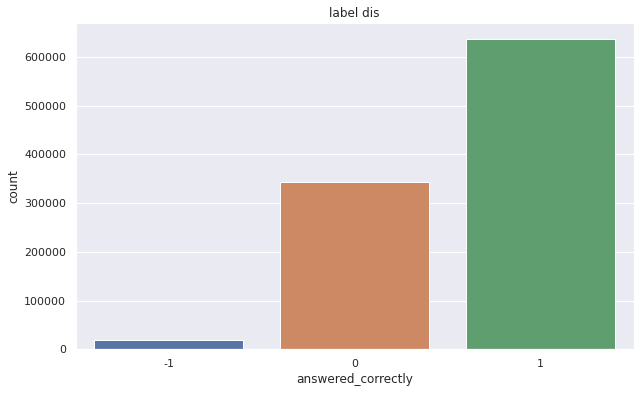

In [9]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train,x='answered_correctly')
plt.title('label dis')  # -1 是讲座  调成平衡可能对auc有帮助，一般经验：1比百分之一采用过采样，一般auc会涨

<AxesSubplot:xlabel='user_id', ylabel='count'>

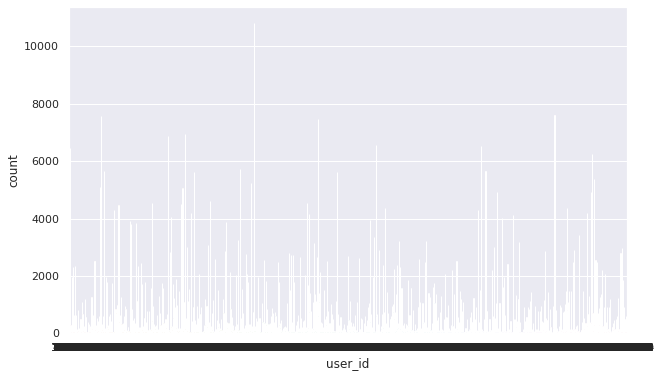

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=train,x='user_id')

In [14]:
train.groupby(['user_id'])['row_id'].count().reset_index() #看用户点了多少。一般拉几个有显著性的用户

,user_id,row_id
0,115,46
1,124,30
2,2746,20
3,5382,128
4,8623,112
...,...,...
3819,20913319,416
3820,20913864,21
3821,20938253,535
3822,20948951,51


In [71]:
d = train.groupby(['user_id'])['row_id'].count().reset_index()  # 小于十条的就不要了
d1 = d.sort_values(['row_id']).where(d['row_id']>10).dropna().astype(int)
d1

,user_id,row_id
321,1960671,11
554,3189816,11
1835,10184658,11
82,422628,11
2151,11814782,11
...,...,...
796,4421282,6962
1707,9418512,7482
218,1283420,7569
3329,18122922,7593


In [10]:
train[train['user_id']==13923501]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
681638,681638,0,13923501,128,0,0,0,NaN,NaN
681639,681639,21634,13923501,7860,0,1,1,17000.0,False
681640,681640,40349,13923501,7922,0,2,1,19000.0,False
681641,681641,59306,13923501,156,0,3,1,17000.0,False
681642,681642,77009,13923501,51,0,4,1,16000.0,False
...,...,...,...,...,...,...,...,...,...
682375,682375,63585499805,13923501,11477,0,18,1,28000.0,True
682376,682376,63750085762,13923501,9259,0,19,0,28000.0,True
682377,682377,63959939682,13923501,6668,0,20,0,47000.0,True
682378,682378,64005323240,13923501,6451,0,21,1,17000.0,True


In [24]:
train[train['user_id']==15960740]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
783331,783331,0,15960740,5585,0,0,1,NaN,NaN
783332,783332,32301,15960740,7924,0,1,0,77000.0,False


In [76]:
train.groupby(['timestamp'])['row_id'].count().reset_index()
# 从该用户交互到该用户第一次事件完成之间的时间（以毫秒为单位）。

,timestamp,row_id
0,0,3847
1,2570,1
2,3395,1
3,3699,1
4,4124,1
...,...,...
769352,76809455168,3
769353,76809663509,3
769354,76809860397,3
769355,76810038254,3


In [74]:
train.groupby(['task_container_id'])['row_id'].count().reset_index() 
#这批问题或讲座的ID代码。例如，用户可能会先看到三个问题，然后再查看其中任何一个的解释。这三个都将共享一个task_container_id。

,task_container_id,row_id
0,-128,3608
1,-127,3565
2,-126,3541
3,-125,3547
4,-124,3553
...,...,...
251,123,3688
252,124,3638
253,125,3617
254,126,3563


# 用户行为次数分布

Text(0, 0.5, 'Pro')

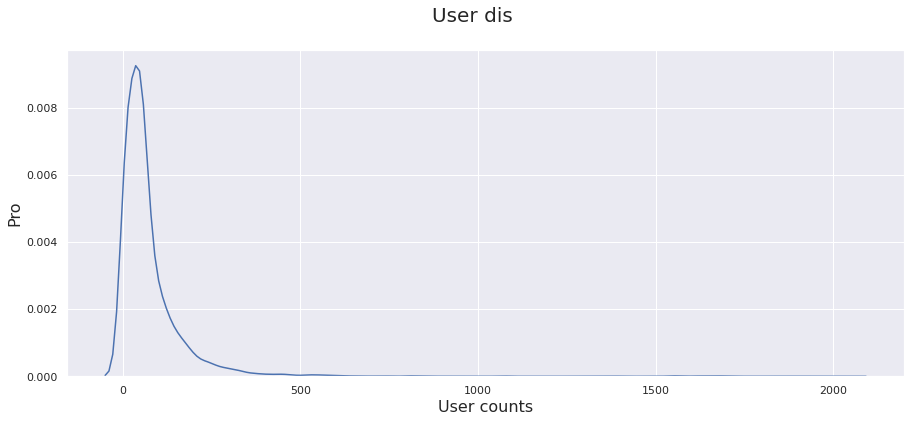

In [84]:
sns.set()
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(train.groupby('content_id')['row_id'].count()) # 核密度估计图 content_id：（int16）用户交互的ID代码 问题id
fig.figure.suptitle('User dis',fontsize=20)
plt.xlabel('User counts',fontsize=16)
plt.ylabel('Pro',fontsize=16)

Text(0, 0.5, 'Pro')

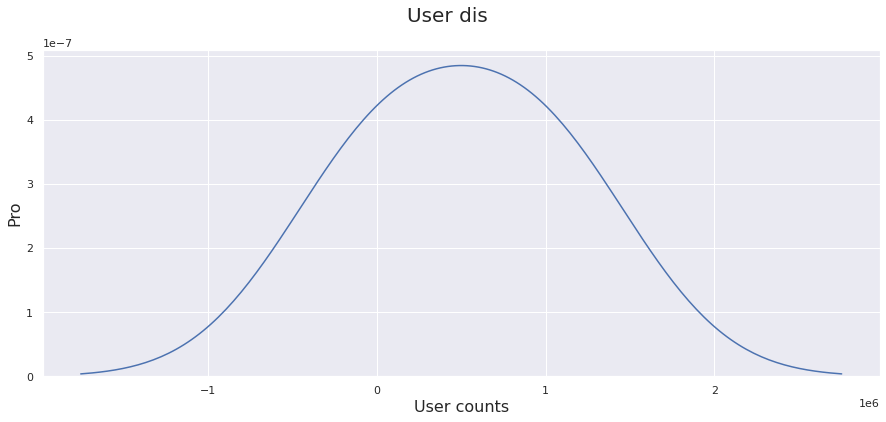

In [85]:
sns.set()
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(train.groupby('content_type_id')['row_id'].count())  #content_type_id：（int8）如果事件是向用户提出的问题，则为0；如果事件是用户正在观看讲座，则为1。
fig.figure.suptitle('content_type_id dis',fontsize=20)
plt.xlabel('User counts',fontsize=16)
plt.ylabel('Pro',fontsize=16)

In [5]:
from collections import Counter
Counter(train[train['user_id']==7171715]['content_type_id'])

Counter({0: 10797, 1: 29})

In [8]:
Counter(train['content_type_id'])

Counter({0: 980093, 1: 19907})

In [90]:
train[(train['user_id']==7171715) & (train['content_type_id']==1)]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
371543,371543,22399692,7171715,10742,1,50,-1,NaN,False
371548,371548,22419584,7171715,20590,1,53,-1,NaN,False
371556,371556,22439172,7171715,27204,1,56,-1,NaN,False
371566,371566,22468113,7171715,10688,1,59,-1,NaN,False
371583,371583,22519270,7171715,17519,1,63,-1,NaN,False
371592,371592,22541214,7171715,23716,1,66,-1,NaN,False
371601,371601,22563747,7171715,10032,1,70,-1,NaN,False
371610,371610,22582620,7171715,10217,1,72,-1,NaN,False
372375,372375,27410142,7171715,6081,1,-126,-1,NaN,False
372380,372380,27436782,7171715,22596,1,-124,-1,NaN,False


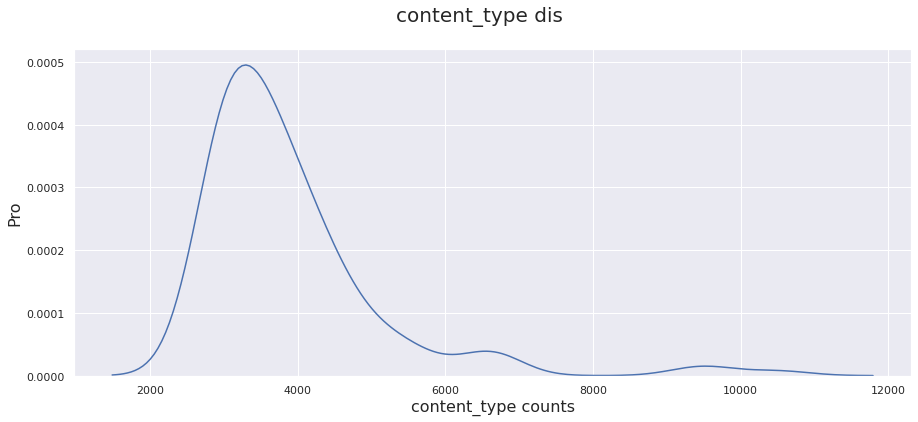

In [94]:
sns.set()
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(train.groupby(by='task_container_id')['row_id'].count())
fig.figure.suptitle("content_type dis", fontsize = 20)
plt.xlabel('content_type counts', fontsize=16)
plt.ylabel('Pro', fontsize=16);

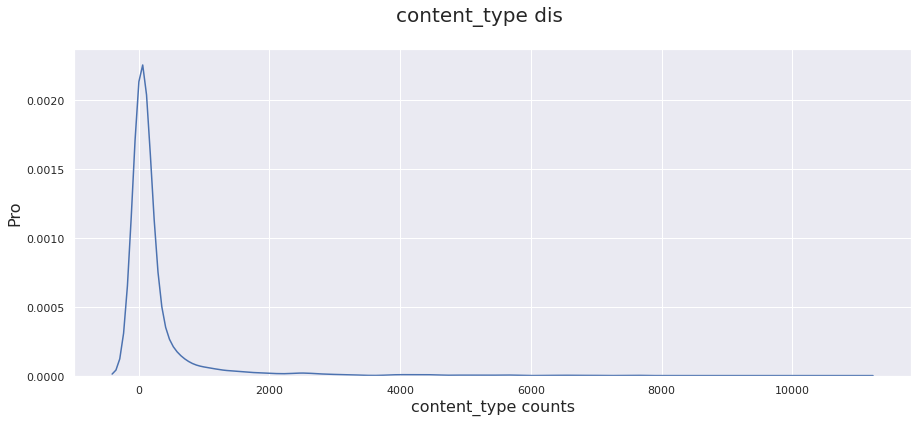

In [96]:
sns.set()
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(train.groupby(by='user_id')['row_id'].count())
fig.figure.suptitle("content_type dis", fontsize = 20)
plt.xlabel('content_type counts', fontsize=16)
plt.ylabel('Pro', fontsize=16);

In [98]:
train[train['answered_correctly']!=-1].groupby(['user_id'])['answered_correctly'].agg([np.mean,np.std,np.max])

,mean,std,amax
user_id,,,
115,0.695652,0.465215,1
124,0.233333,0.430183,1
2746,0.578947,0.507257,1
5382,0.672000,0.471374,1
8623,0.642202,0.481566,1
...,...,...,...
20913319,0.630653,0.483235,1
20913864,0.333333,0.483046,1
20938253,0.608779,0.488490,1


In [99]:
train[train['user_id']==7171715].groupby(['user_id'])['answered_correctly'].agg([np.mean,np.std,np.max])

,mean,std,amax
user_id,,,
7171715,0.258082,0.44368,1


In [100]:
for column in train.columns:
    print('columns:',column)
    print(train[column].value_counts())
    print()

columns: row_id
2047      1
796880    1
841934    1
835789    1
837836    1
         ..
370206    1
376349    1
374300    1
364059    1
0         1
Name: row_id, Length: 1000000, dtype: int64

columns: timestamp
0              3847
835816            8
710382            8
846304            8
151868            7
               ... 
1658113596        1
40435030777       1
618496762         1
4578972408        1
4573904904        1
Name: timestamp, Length: 769357, dtype: int64

columns: user_id
7171715     10826
18122922     7593
1283420      7569
9418512      7482
4421282      6962
            ...  
1946295         3
2148001         2
15960740        2
19887248        1
1880240         1
Name: user_id, Length: 3824, dtype: int64

columns: content_id
6116     2041
6173     1978
4120     1924
175      1877
7876     1847
         ... 
12960       1
12378       1
12893       1
12961       1
13165       1
Name: content_id, Length: 13320, dtype: int64

columns: content_type_id
0    980093
1    

In [101]:
def get_rate(x,b=20):  # 平滑
    # y/(x+b)
    return np.sum(x)/(np.size(x)+20)

In [102]:
train.groupby(['user_id'])['answered_correctly'].agg(lambda x: get_rate(x,b=30))

user_id
115         0.484848
124         0.140000
2746        0.250000
5382        0.547297
8623        0.507576
              ...   
20913319    0.534404
20913864    0.170732
20938253    0.554955
20948951    0.436620
20949024    0.220588
Name: answered_correctly, Length: 3824, dtype: float64

In [103]:
set(train['prior_question_had_explanation'])

{'False', 'True', nan}

In [104]:
train['prior_question_had_explanation'].value_counts()

True     889887
False    106297
Name: prior_question_had_explanation, dtype: int64

In [109]:
train['prior_question_had_explanation']=train['prior_question_had_explanation'].map({'False':0,'True':1})

In [110]:
train['prior_question_had_explanation']

0         NaN
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
999995    1.0
999996    1.0
999997    1.0
999998    1.0
999999    1.0
Name: prior_question_had_explanation, Length: 1000000, dtype: float64

# 用户特征分析

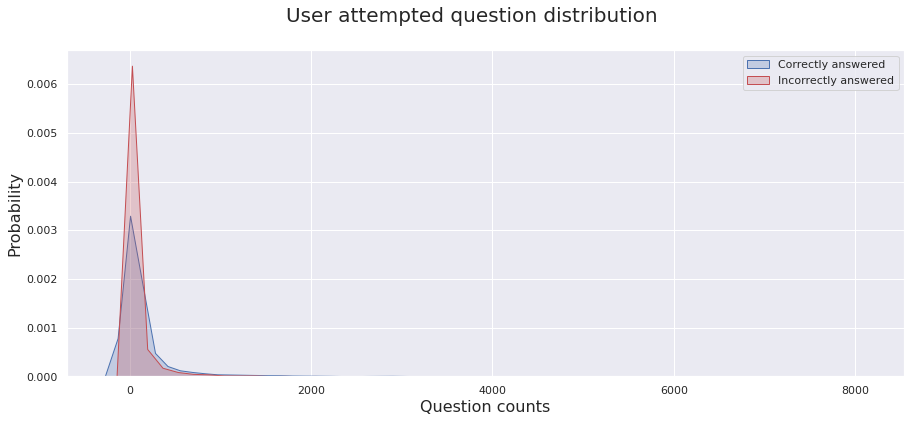

In [111]:
df = train[train['content_type_id']==0]

df2 = df[df['answered_correctly']==1]
df3 = df[df['answered_correctly']==0]

df2 = df2.groupby(by='user_id').count()
df3 = df3.groupby(by='user_id').count()

fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(df2['row_id'],shade=True,gridsize=50,color='b',legend=False)
fig = sns.kdeplot(df3['row_id'],shade=True,gridsize=50,color='r',legend=False)

fig.figure.suptitle('User attempted question distribution',fontsize=20)
plt.xlabel('Question counts',fontsize=16)
plt.ylabel('Probability',fontsize=16)
plt.legend(['Correctly answered','Incorrectly answered'])

In [112]:
train.groupby(['user_id']).size().reset_index() # 答题次数也会作为特征

,user_id,0
0,115,46
1,124,30
2,2746,20
3,5382,128
4,8623,112
...,...,...
3819,20913319,416
3820,20913864,21
3821,20938253,535
3822,20948951,51


In [114]:
questions.head()  # 序列可以用wordcount 和 tfidf做 tags

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38


In [138]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  13523 non-null  int16 
 1   bundle_id    13523 non-null  int16 
 2   part         13523 non-null  int8  
 3   tags         13522 non-null  object
 4   part_1       13523 non-null  int64 
dtypes: int16(2), int64(1), int8(1), object(1)
memory usage: 277.5+ KB


In [120]:
# Counter(questions.bundle_id) # 一一对应的用处不大

In [121]:
Counter(questions.part) # 这么几个特征可以

Counter({1: 992, 2: 1647, 3: 1562, 4: 1439, 5: 5511, 6: 1212, 7: 1160})

In [135]:
from tqdm import tqdm
tqdm.pandas(desc='map')
# questions['part_992'] 可以这么做 或 onehot
questions['part_1'] = questions['part'].map(lambda x:1 if x==1 else 0)
# .map({'992':1})
set(questions['part_1'])

{0, 1}

In [139]:
questions.tags.map(lambda x: str(x).split(' '))

0         [51, 131, 162, 38]
1              [131, 36, 81]
2        [131, 101, 162, 92]
3        [131, 149, 162, 29]
4          [131, 5, 162, 38]
                ...         
13518                   [14]
13519                    [8]
13520                   [73]
13521                  [125]
13522                   [55]
Name: tags, Length: 13523, dtype: object

In [140]:
tags_list=[]
for c in questions.tags.map(lambda x:str(x).split(' ')):
    tags_list += c
Counter(tags_list)

Counter({'51': 71,
         '131': 650,
         '162': 914,
         '38': 2256,
         '36': 35,
         '81': 1969,
         '101': 52,
         '92': 2269,
         '149': 53,
         '29': 1707,
         '5': 85,
         '10': 293,
         '94': 27,
         '61': 49,
         '110': 49,
         '13': 24,
         '164': 56,
         '99': 36,
         '93': 58,
         '70': 46,
         '9': 124,
         '104': 72,
         '40': 27,
         '130': 37,
         '187': 45,
         '102': 789,
         '111': 38,
         '178': 39,
         '143': 712,
         '30': 105,
         '90': 214,
         '100': 203,
         '176': 105,
         '140': 112,
         '6': 8,
         '2': 144,
         '107': 120,
         '114': 121,
         '138': 104,
         '41': 100,
         '141': 65,
         '137': 115,
         '142': 17,
         '119': 93,
         '148': 110,
         '69': 69,
         '62': 194,
         '155': 209,
         '163': 132,
         '129': 50,

In [141]:
len(set(tags_list))  # 最简单处理是变成189个特征，但这个题内存有限制不适用

189

In [142]:
questions['tags_51'] = questions['tags'].map(lambda x: 1 if '51' in str(x) else 0)

In [143]:
questions

,question_id,bundle_id,part,tags,part_1,tags_51
0,0,0,1,51 131 162 38,1,1
1,1,1,1,131 36 81,1,0
2,2,2,1,131 101 162 92,1,0
3,3,3,1,131 149 162 29,1,0
4,4,4,1,131 5 162 38,1,0
...,...,...,...,...,...,...
13518,13518,13518,5,14,0,0
13519,13519,13519,5,8,0,0
13520,13520,13520,5,73,0,0
13521,13521,13521,5,125,0,0


In [144]:
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [145]:
Counter(lectures.part)

Counter({5: 143, 1: 54, 6: 83, 2: 56, 7: 32, 3: 19, 4: 31})

In [146]:
Counter(lectures.tag)

Counter({159: 4,
         70: 5,
         45: 3,
         79: 4,
         156: 4,
         114: 5,
         179: 4,
         134: 6,
         93: 2,
         80: 3,
         98: 3,
         101: 4,
         33: 3,
         74: 6,
         60: 3,
         181: 4,
         43: 3,
         4: 4,
         109: 4,
         89: 3,
         142: 2,
         140: 2,
         104: 2,
         1: 4,
         65: 3,
         155: 1,
         26: 4,
         178: 2,
         173: 5,
         7: 3,
         147: 2,
         171: 1,
         78: 2,
         62: 6,
         64: 4,
         141: 3,
         124: 2,
         161: 6,
         24: 2,
         23: 2,
         152: 4,
         8: 4,
         94: 5,
         119: 5,
         37: 2,
         177: 3,
         54: 3,
         157: 4,
         132: 2,
         6: 2,
         67: 1,
         123: 3,
         50: 2,
         25: 3,
         175: 2,
         116: 6,
         136: 7,
         20: 2,
         129: 3,
         127: 3,
         53: 4,

In [147]:
Counter(lectures.type_of)

Counter({'concept': 222,
         'solving question': 186,
         'intention': 7,
         'starter': 3})

In [149]:
lectures['type_of_concept'] = lectures['type_of'].map(lambda x: 1 if 'concept' in str(x) else 0)

In [150]:
lectures['type_of_solving'] = lectures['type_of'].map(lambda x: 1 if 'solving question' in str(x) else 0)
lectures['type_of_intention'] = lectures['type_of'].map(lambda x: 1 if 'intention' in str(x) else 0)
lectures['type_of_starter'] = lectures['type_of'].map(lambda x: 1 if 'starter' in str(x) else 0)

In [151]:
lectures

,lecture_id,tag,part,type_of,type_of_concept,type_of_solving,type_of_intention,type_of_starter
0,89,159,5,concept,1,0,0,0
1,100,70,1,concept,1,0,0,0
2,185,45,6,concept,1,0,0,0
3,192,79,5,solving question,0,1,0,0
4,317,156,5,solving question,0,1,0,0
...,...,...,...,...,...,...,...,...
413,32535,8,5,solving question,0,1,0,0
414,32570,113,3,solving question,0,1,0,0
415,32604,24,6,concept,1,0,0,0
416,32625,142,2,concept,1,0,0,0
